# Natural Language Processing (NLP)

## Introduction

*Adapted from [NLP Crash Course](http://files.meetup.com/7616132/DC-NLP-2013-09%20Charlie%20Greenbacker.pdf) by Charlie Greenbacker and [Introduction to NLP](http://spark-public.s3.amazonaws.com/nlp/slides/intro.pdf) by Dan Jurafsky*

### What is NLP?

- Using computers to process (analyze, understand, generate) natural human languages
- Most knowledge created by humans is unstructured text, and we need a way to make sense of it
- Build probabilistic model using data about a language

### What are some of the higher level task areas?

- **Information retrieval**: Find relevant results and similar results
    - [Google](https://www.google.com/)
- **Information extraction**: Structured information from unstructured documents
    - [Events from Gmail](https://support.google.com/calendar/answer/6084018?hl=en)
- **Machine translation**: One language to another
    - [Google Translate](https://translate.google.com/)
- **Text simplification**: Preserve the meaning of text, but simplify the grammar and vocabulary
    - [Rewordify](https://rewordify.com/)
    - [Simple English Wikipedia](https://simple.wikipedia.org/wiki/Main_Page)
- **Predictive text input**: Faster or easier typing
    - [My application](https://justmarkham.shinyapps.io/textprediction/)
    - [A much better application](https://farsite.shinyapps.io/swiftkey-cap/)
- **Sentiment analysis**: Attitude of speaker
    - [Hater News](http://haternews.herokuapp.com/)
- **Automatic summarization**: Extractive or abstractive summarization
    - [autotldr](https://www.reddit.com/r/technology/comments/35brc8/21_million_people_still_use_aol_dialup/cr2zzj0)
- **Natural Language Generation**: Generate text from data
    - [How a computer describes a sports match](http://www.bbc.com/news/technology-34204052)
    - [Publishers withdraw more than 120 gibberish papers](http://www.nature.com/news/publishers-withdraw-more-than-120-gibberish-papers-1.14763)
- **Speech recognition and generation**: Speech-to-text, text-to-speech
    - [Google's Web Speech API demo](https://www.google.com/intl/en/chrome/demos/speech.html)
    - [Vocalware Text-to-Speech demo](https://www.vocalware.com/index/demo)
- **Question answering**: Determine the intent of the question, match query with knowledge base, evaluate hypotheses
    - [How did supercomputer Watson beat Jeopardy champion Ken Jennings?](http://blog.ted.com/how-did-supercomputer-watson-beat-jeopardy-champion-ken-jennings-experts-discuss/)
    - [IBM's Watson Trivia Challenge](http://www.nytimes.com/interactive/2010/06/16/magazine/watson-trivia-game.html)
    - [The AI Behind Watson](http://www.aaai.org/Magazine/Watson/watson.php)

### What are some of the lower level components?

- **Tokenization**: breaking text into tokens (words, sentences, n-grams)
- **Stopword removal**: a/an/the
- **Stemming and lemmatization**: root word
- **TF-IDF**: word importance
- **Part-of-speech tagging**: noun/verb/adjective
- **Named entity recognition**: person/organization/location
- **Spelling correction**: "New Yrok City"
- **Word sense disambiguation**: "buy a mouse"
- **Segmentation**: "New York City subway"
- **Language detection**: "translate this page"
- **Machine learning**

### Why is NLP hard?

- **Ambiguity**:
    - Hospitals are Sued by 7 Foot Doctors
    - Juvenile Court to Try Shooting Defendant
    - Local High School Dropouts Cut in Half
- **Non-standard English**: text messages
- **Idioms**: "throw in the towel"
- **Newly coined words**: "retweet"
- **Tricky entity names**: "Where is A Bug's Life playing?"
- **World knowledge**: "Mary and Sue are sisters", "Mary and Sue are mothers"

NLP requires an understanding of the **language** and the **world**.

## Part 1: Reading in the Yelp Reviews

- "corpus" = collection of documents
- "corpora" = plural form of corpus

In [26]:
from __future__ import print_function
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word  # conda install -c conda-forge textblob=0.12.0
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [27]:
# read yelp.csv into a DataFrame
yelp = pd.read_csv('data/yelp.csv')

yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [28]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

yelp_best_worst.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4


In [29]:
# define X and y
X = yelp_best_worst.text
y = yelp_best_worst.stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Part 2: Tokenization

- **What:** Separate text into units such as sentences or words
- **Why:** Gives structure to previously unstructured text
- **Notes:** Relatively easy with English language text, not easy with some languages

In [30]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [31]:
# rows are documents, columns are terms (aka "tokens" or "features")
X_train_dtm.shape

(3064, 16825)

In [32]:
# last 50 features
vect.get_feature_names()[-50:]

[u'yyyyy',
 u'z11',
 u'za',
 u'zabba',
 u'zach',
 u'zam',
 u'zanella',
 u'zankou',
 u'zappos',
 u'zatsiki',
 u'zen',
 u'zero',
 u'zest',
 u'zexperience',
 u'zha',
 u'zhou',
 u'zia',
 u'zihuatenejo',
 u'zilch',
 u'zin',
 u'zinburger',
 u'zinburgergeist',
 u'zinc',
 u'zinfandel',
 u'zing',
 u'zip',
 u'zipcar',
 u'zipper',
 u'zippers',
 u'zipps',
 u'ziti',
 u'zoe',
 u'zombi',
 u'zombies',
 u'zone',
 u'zones',
 u'zoning',
 u'zoo',
 u'zoyo',
 u'zucca',
 u'zucchini',
 u'zuchinni',
 u'zumba',
 u'zupa',
 u'zuzu',
 u'zwiebel',
 u'zzed',
 u'\xe9clairs',
 u'\xe9cole',
 u'\xe9m']

In [33]:
# show vectorizer options
vect

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

[CountVectorizer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

- **lowercase:** boolean, True by default
- Convert all characters to lowercase before tokenizing.

In [34]:
# don't convert to lowercase
vect = CountVectorizer(lowercase=False)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 20838)

- **ngram_range:** tuple (min_n, max_n)
- The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

In [35]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape

(3064, 169847)

In [37]:
# last 50 features
vect.get_feature_names()[-50:]

[u'zone out',
 u'zone when',
 u'zones',
 u'zones dolls',
 u'zoning',
 u'zoning issues',
 u'zoo',
 u'zoo and',
 u'zoo is',
 u'zoo not',
 u'zoo the',
 u'zoo ve',
 u'zoyo',
 u'zoyo for',
 u'zucca',
 u'zucca appetizer',
 u'zucchini',
 u'zucchini and',
 u'zucchini bread',
 u'zucchini broccoli',
 u'zucchini carrots',
 u'zucchini fries',
 u'zucchini pieces',
 u'zucchini strips',
 u'zucchini veal',
 u'zucchini very',
 u'zucchini with',
 u'zuchinni',
 u'zuchinni again',
 u'zuchinni the',
 u'zumba',
 u'zumba class',
 u'zumba or',
 u'zumba yogalates',
 u'zupa',
 u'zupa flavors',
 u'zuzu',
 u'zuzu in',
 u'zuzu is',
 u'zuzu the',
 u'zwiebel',
 u'zwiebel kr\xe4uter',
 u'zzed',
 u'zzed in',
 u'\xe9clairs',
 u'\xe9clairs napoleons',
 u'\xe9cole',
 u'\xe9cole len\xf4tre',
 u'\xe9m',
 u'\xe9m all']

**Predicting the star rating:**

In [39]:
# use default options for CountVectorizer
vect = CountVectorizer()

# create document-term matrices
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# use Naive Bayes to predict the star rating
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

metrics_nb = metrics.accuracy_score(y_test, y_pred_class)
metrics_nb

0.91878669275929548

In [40]:
# calculate null accuracy
y_test_binary = np.where(y_test==5, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

0.81996086105675148

In [43]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print ('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print ('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [44]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
tokenize_test(vect)

Features:  169847
Accuracy:  0.854207436399


## Part 3: Stopword Removal

- **What:** Remove common words that will likely appear in any text
- **Why:** They don't tell you much about your text

In [45]:
# show vectorizer options
vect

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

- **stop_words:** string {'english'}, list, or None (default)
- If 'english', a built-in stop word list for English is used.
- If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
- If None, no stop words will be used. max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.

In [46]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)

Features:  16528
Accuracy:  0.915851272016


In [47]:
# set of stop words
vect.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

## Part 4: Other CountVectorizer Options

- **max_features:** int or None, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [48]:
# remove English stop words and only keep 100 features
vect = CountVectorizer(stop_words='english', max_features=100)
tokenize_test(vect)

Features:  100
Accuracy:  0.869863013699


In [49]:
# all 100 features
vect.get_feature_names()

[u'amazing',
 u'area',
 u'atmosphere',
 u'awesome',
 u'bad',
 u'bar',
 u'best',
 u'better',
 u'big',
 u'came',
 u'cheese',
 u'chicken',
 u'clean',
 u'coffee',
 u'come',
 u'day',
 u'definitely',
 u'delicious',
 u'did',
 u'didn',
 u'dinner',
 u'don',
 u'eat',
 u'excellent',
 u'experience',
 u'favorite',
 u'feel',
 u'food',
 u'free',
 u'fresh',
 u'friendly',
 u'friends',
 u'going',
 u'good',
 u'got',
 u'great',
 u'happy',
 u'home',
 u'hot',
 u'hour',
 u'just',
 u'know',
 u'like',
 u'little',
 u'll',
 u'location',
 u'long',
 u'looking',
 u'lot',
 u'love',
 u'lunch',
 u'make',
 u'meal',
 u'menu',
 u'minutes',
 u'need',
 u'new',
 u'nice',
 u'night',
 u'order',
 u'ordered',
 u'people',
 u'perfect',
 u'phoenix',
 u'pizza',
 u'place',
 u'pretty',
 u'prices',
 u'really',
 u'recommend',
 u'restaurant',
 u'right',
 u'said',
 u'salad',
 u'sandwich',
 u'sauce',
 u'say',
 u'service',
 u'staff',
 u'store',
 u'sure',
 u'table',
 u'thing',
 u'things',
 u'think',
 u'time',
 u'times',
 u'took',
 u'town',


In [50]:
# include 1-grams and 2-grams, and limit the number of features
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

Features:  100000
Accuracy:  0.885518590998


- **min_df:** float in range [0.0, 1.0] or int, default=1
- When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

In [51]:
# include 1-grams and 2-grams, and only include terms that appear at least 2 times
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

Features:  43957
Accuracy:  0.932485322896


## Part 5: Introduction to TextBlob

TextBlob: "Simplified Text Processing"

In [52]:
# print the first review
yelp_best_worst.text[0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [53]:
# save it as a TextBlob object
review = TextBlob(yelp_best_worst.text[0])

In [54]:
# list the words
review.words

WordList(['My', 'wife', 'took', 'me', 'here', 'on', 'my', 'birthday', 'for', 'breakfast', 'and', 'it', 'was', 'excellent', 'The', 'weather', 'was', 'perfect', 'which', 'made', 'sitting', 'outside', 'overlooking', 'their', 'grounds', 'an', 'absolute', 'pleasure', 'Our', 'waitress', 'was', 'excellent', 'and', 'our', 'food', 'arrived', 'quickly', 'on', 'the', 'semi-busy', 'Saturday', 'morning', 'It', 'looked', 'like', 'the', 'place', 'fills', 'up', 'pretty', 'quickly', 'so', 'the', 'earlier', 'you', 'get', 'here', 'the', 'better', 'Do', 'yourself', 'a', 'favor', 'and', 'get', 'their', 'Bloody', 'Mary', 'It', 'was', 'phenomenal', 'and', 'simply', 'the', 'best', 'I', "'ve", 'ever', 'had', 'I', "'m", 'pretty', 'sure', 'they', 'only', 'use', 'ingredients', 'from', 'their', 'garden', 'and', 'blend', 'them', 'fresh', 'when', 'you', 'order', 'it', 'It', 'was', 'amazing', 'While', 'EVERYTHING', 'on', 'the', 'menu', 'looks', 'excellent', 'I', 'had', 'the', 'white', 'truffle', 'scrambled', 'eggs', 

In [55]:
# list the sentences
review.sentences

[Sentence("My wife took me here on my birthday for breakfast and it was excellent."),
 Sentence("The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure."),
 Sentence("Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning."),
 Sentence("It looked like the place fills up pretty quickly so the earlier you get here the better."),
 Sentence("Do yourself a favor and get their Bloody Mary."),
 Sentence("It was phenomenal and simply the best I've ever had."),
 Sentence("I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it."),
 Sentence("It was amazing."),
 Sentence("While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious."),
 Sentence("It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete."),
 Sentence("It was the best "toast" I've ever had."),


In [56]:
# some string methods are available
review.lower()

TextBlob("my wife took me here on my birthday for breakfast and it was excellent.  the weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  our waitress was excellent and our food arrived quickly on the semi-busy saturday morning.  it looked like the place fills up pretty quickly so the earlier you get here the better.

do yourself a favor and get their bloody mary.  it was phenomenal and simply the best i've ever had.  i'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  it was amazing.

while everything on the menu looks excellent, i had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  it came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  it was the best "toast" i've ever had.

anyway, i can't wait to go back!")

## Part 6: Stemming and Lemmatization

**Stemming:**

- **What:** Reduce a word to its base/stem/root form
- **Why:** Often makes sense to treat related words the same way
- **Notes:**
    - Uses a "simple" and fast rule-based approach
    - Stemmed words are usually not shown to users (used for analysis/indexing)
    - Some search engines treat words with the same stem as synonyms

In [57]:
# initialize stemmer
stemmer = SnowballStemmer('english')

# stem each word
stemmed = [stemmer.stem(word) for word in review.words]
stemmed[:33]

[u'my',
 u'wife',
 u'took',
 u'me',
 u'here',
 u'on',
 u'my',
 u'birthday',
 u'for',
 u'breakfast',
 u'and',
 u'it',
 u'was',
 u'excel',
 u'the',
 u'weather',
 u'was',
 u'perfect',
 u'which',
 u'made',
 u'sit',
 u'outsid',
 u'overlook',
 u'their',
 u'ground',
 u'an',
 u'absolut',
 u'pleasur',
 u'our',
 u'waitress',
 u'was',
 u'excel',
 u'and']

**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [58]:
# assume every word is a noun
lemmas =  [word.lemmatize() for word in review.words]
lemmas[:33]

['My',
 'wife',
 'took',
 'me',
 'here',
 'on',
 'my',
 'birthday',
 'for',
 'breakfast',
 'and',
 'it',
 u'wa',
 'excellent',
 'The',
 'weather',
 u'wa',
 'perfect',
 'which',
 'made',
 'sitting',
 'outside',
 'overlooking',
 'their',
 u'ground',
 'an',
 'absolute',
 'pleasure',
 'Our',
 'waitress',
 u'wa',
 'excellent',
 'and']

In [59]:
# assume every word is a verb
lemmas_v =  [word.lemmatize(pos='v') for word in review.words]
lemmas_v[:33]

['My',
 'wife',
 u'take',
 'me',
 'here',
 'on',
 'my',
 'birthday',
 'for',
 'breakfast',
 'and',
 'it',
 u'be',
 'excellent',
 'The',
 'weather',
 u'be',
 'perfect',
 'which',
 u'make',
 u'sit',
 'outside',
 u'overlook',
 'their',
 u'ground',
 'an',
 'absolute',
 'pleasure',
 'Our',
 'waitress',
 u'be',
 'excellent',
 'and']

In [60]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = unicode(text, 'utf-8').lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [61]:
# use split_into_lemmas as the feature extraction function (WARNING: SLOW!)
vect = CountVectorizer(analyzer=split_into_lemmas)
tokenize_test(vect)

Features:  16452
Accuracy:  0.920743639922


In [62]:
# last 50 features
vect.get_feature_names()[-50:]

[u'yuyuyummy',
 u'yuzu',
 u'z',
 u'z-grill',
 u'z11',
 u'zach',
 u'zam',
 u'zanella',
 u'zankou',
 u'zappos',
 u'zatsiki',
 u'zen',
 u'zen-like',
 u'zero',
 u'zero-star',
 u'zest',
 u'zexperience',
 u'zha',
 u'zhou',
 u'zia',
 u'zilch',
 u'zin',
 u'zinburger',
 u'zinburgergeist',
 u'zinc',
 u'zinfandel',
 u'zing',
 u'zip',
 u'zipcar',
 u'zipper',
 u'zipps',
 u'ziti',
 u'zoe',
 u'zombi',
 u'zombie',
 u'zone',
 u'zoning',
 u'zoo',
 u'zoyo',
 u'zucca',
 u'zucchini',
 u'zuchinni',
 u'zumba',
 u'zupa',
 u'zuzu',
 u'zwiebel-kr\xe4uter',
 u'zzed',
 u'\xe9clairs',
 u'\xe9cole',
 u'\xe9m']

## Part 7: Term Frequency-Inverse Document Frequency (TF-IDF)

- **What:** Computes "relative frequency" that a word appears in a document compared to its frequency across all documents
- **Why:** More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
- **Notes:** Used for search engine scoring, text summarization, document clustering

In [63]:
# example documents
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [64]:
# Term Frequency
vect = CountVectorizer()
tf = pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())
tf

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [65]:
# Document Frequency
vect = CountVectorizer(binary=True)
df = vect.fit_transform(simple_train).toarray().sum(axis=0)
pd.DataFrame(df.reshape(1, 6), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,1,3,2,1,1,1


In [66]:
# Term Frequency-Inverse Document Frequency (simple version)
tf/df

,cab,call,me,please,tonight,you
0,0.0,0.333333,0.0,0.0,1.0,1.0
1,1.0,0.333333,0.5,0.0,0.0,0.0
2,0.0,0.333333,0.5,2.0,0.0,0.0


In [67]:
# TfidfVectorizer
vect = TfidfVectorizer()
pd.DataFrame(vect.fit_transform(simple_train).toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0.000000,0.385372,0.000000,0.000000,0.652491,0.652491
1,0.720333,0.425441,0.547832,0.000000,0.000000,0.000000
2,0.000000,0.266075,0.342620,0.901008,0.000000,0.000000


**More details:** [TF-IDF is about what matters](http://planspace.org/20150524-tfidf_is_about_what_matters/)

## Part 8: Using TF-IDF to Summarize a Yelp Review

Reddit's autotldr uses the [SMMRY](http://smmry.com/about) algorithm, which is based on TF-IDF!

In [68]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp.text)
features = vect.get_feature_names()
dtm.shape

(10000, 28880)

In [70]:
def summarize():
    
    # choose a random review that is at least 300 characters
    review_length = 0
    while review_length < 300:
        review_id = np.random.randint(0, len(yelp))
        review_text = unicode(yelp.text[review_id], 'utf-8')
        review_length = len(review_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(review_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print ('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print (word)
    
    # print 5 random words
    print ('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(word_scores.keys(), size=5, replace=False)
    for word in random_words:
        print (word)
    
    # print the review
    print ('\n' + review_text)

In [71]:
summarize()

TOP SCORING WORDS:
toppings
proportioned
noticeably
crimini
earn

RANDOM WORDS:
salad
proportioned
fresh
noticeably
night

I was pleasantly surprised by Sauce. We went here for dinner last night, and wanted something quick, tasty and casual. Done. I think of it as a cross between a fast food place and a pizzeria.

I had the Pepperoni and Crimini Mushroom pizza, and it was great. The crust is amazingly thin yet perfect for the pie. The center where the toppings are is a nice and soft but the edges are super crispy with a chip-like "crunch". The sauce and toppings were noticeably fresh and perfectly proportioned on the pizza.

M had the Turkey salad, and she too was very pleased. I can describe hers much - as we both stuck to our plates!

The waitstaff was very pleasant and everything came out well; however nothing really blew me away to earn that 5th star.


## Part 9: Sentiment Analysis

In [72]:
review

TextBlob("My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!")

In [73]:
# polarity ranges from -1 (most negative) to 1 (most positive)
review.sentiment.polarity

0.40246913580246907

In [74]:
# understanding the apply method
yelp['length'] = yelp.text.apply(len)
yelp.head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889


In [75]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [76]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
yelp['sentiment'] = yelp.text.apply(detect_sentiment)

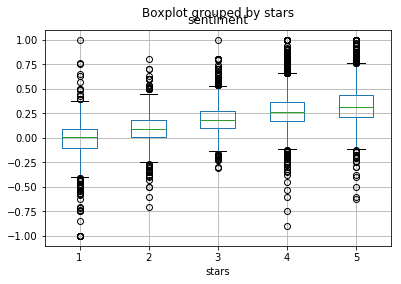

In [77]:
# box plot of sentiment grouped by stars
yelp.boxplot(column='sentiment', by='stars')

In [78]:
# reviews with most positive sentiment
yelp[yelp.sentiment == 1].text.head()

254    Our server Gary was awesome. Food was amazing....
347    3 syllables for this place. \nA-MAZ-ING!\n\nTh...
420                                    LOVE the food!!!!
459    Love it!!! Wish we still lived in Arizona as C...
679                                     Excellent burger
Name: text, dtype: object

In [79]:
# reviews with most negative sentiment
yelp[yelp.sentiment == -1].text.head()

773     This was absolutely horrible. I got the suprem...
1517                  Nasty workers and over priced trash
3266    Absolutely awful... these guys have NO idea wh...
4766                                       Very bad food!
5812        I wouldn't send my worst enemy to this place.
Name: text, dtype: object

In [80]:
# widen the column display
pd.set_option('max_colwidth', 500)

In [81]:
# negative sentiment in a 5-star review
yelp[(yelp.stars == 5) & (yelp.sentiment < -0.3)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,sentiment
390,106JT5p8e8Chtd0CZpcARw,2009-08-06,KowGVoP_gygzdSu6Mt3zKQ,5,"RIP AZ Coffee Connection. :( I stopped by two days ago unaware that they had closed. I am severely bummed. This place is irreplaceable! Damn you, Starbucks and McDonalds!",review,jKeaOrPyJ-dI9SNeVqrbww,1,0,0,175,-0.302083


In [82]:
# positive sentiment in a 1-star review
yelp[(yelp.stars == 1) & (yelp.sentiment > 0.5)].head(1)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,sentiment
1781,53YGfwmbW73JhFiemNeyzQ,2012-06-22,Gi-4O3EhE175vujbFGDIew,1,If you like the stuck up Scottsdale vibe this is a good place for you. The food isn't impressive. Nice outdoor seating.,review,Hqgx3IdJAAaoQjvrUnbNvw,0,1,2,119,0.766667


In [83]:
# reset the column display width
pd.reset_option('max_colwidth')

## Bonus: Adding Features to a Document-Term Matrix

In [84]:
# create a DataFrame that only contains the 5-star and 1-star reviews
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

# define X and y
feature_cols = ['text', 'sentiment', 'cool', 'useful', 'funny']
X = yelp_best_worst[feature_cols]
y = yelp_best_worst.stars

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [85]:
# use CountVectorizer with text column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.text)
X_test_dtm = vect.transform(X_test.text)
print (X_train_dtm.shape)
print (X_test_dtm.shape)

(3064, 16825)
(1022, 16825)


In [86]:
# shape of other four feature columns
X_train.drop('text', axis=1).shape

(3064, 4)

In [87]:
# cast other feature columns to float and convert to a sparse matrix
extra = sp.sparse.csr_matrix(X_train.drop('text', axis=1).astype(float))
extra.shape

(3064, 4)

In [88]:
# combine sparse matrices
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

(3064, 16829)

In [89]:
# repeat for testing set
extra = sp.sparse.csr_matrix(X_test.drop('text', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(1022, 16829)

In [90]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
scores_logreg = metrics.accuracy_score(y_test, y_pred_class)
scores_logreg

0.9178082191780822

In [91]:
# use logistic regression with all features
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
metrics_logreg =  metrics.accuracy_score(y_test, y_pred_class)
metrics_logreg

0.9227005870841487

## Bonus: Fun TextBlob Features

In [92]:
# spelling correction
TextBlob('15 minuets late').correct()

TextBlob("15 minutes late")

In [93]:
# spellcheck
Word('parot').spellcheck()

[('part', 0.9929478138222849), (u'parrot', 0.007052186177715092)]

In [94]:
# definitions
Word('bank').define('v')

[u'tip laterally',
 u'enclose with a bank',
 u'do business with a bank or keep an account at a bank',
 u'act as the banker in a game or in gambling',
 u'be in the banking business',
 u'put into a bank account',
 u'cover with ashes so to control the rate of burning',
 u'have confidence or faith in']

In [95]:
# language identification
TextBlob('Hola amigos').detect_language()

u'es'

## Conclusion

- NLP is a gigantic field
- Understanding the basics broadens the types of data you can work with
- Simple techniques go a long way
- Use scikit-learn for NLP whenever possible